# Fake News Detection Tool


## Installing Necessary Libararies

In [107]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split, StratifiedKFold,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Hadee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hadee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hadee\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading Dataset

In [108]:
data_fake = pd.read_csv("C:\\Users\\Hadee\\OneDrive - Aston University\\Fake News Detection\\Dataset\\Fake.csv")
data_true = pd.read_csv("C:\\Users\\Hadee\\OneDrive - Aston University\\Fake News Detection\\Dataset\\True.csv")



## Previewing Data

In [109]:
data_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [110]:
data_fake.shape

(23481, 4)

In [111]:
data_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [112]:
data_true.shape

(21417, 4)

## Assigning Classes To Datasets

In [113]:
data_fake["class"] = 0 
data_true["class"] = 1 





## Combining Datasets

In [114]:
data=pd.concat([data_fake, data_true], axis = 0)
data.head(10)

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",0
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",0
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",0
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",0
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",0


## Class Distribution 

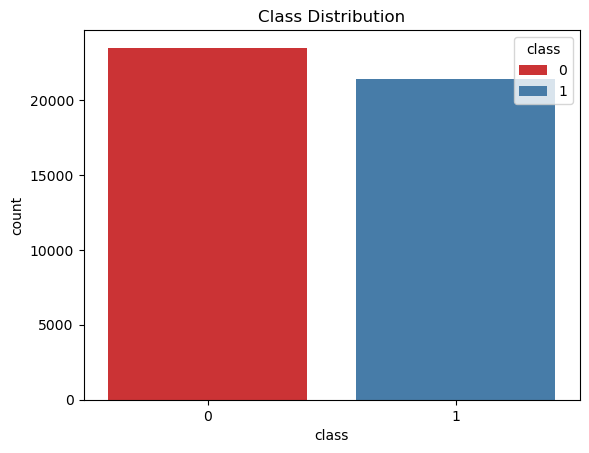

In [115]:
sns.countplot(data=data, 
              x='class', 
              order=data['class'].value_counts().index,
              palette="Set1",hue='class')  
plt.title("Class Distribution")
plt.show()

In [116]:
data['class'].value_counts()

class
0    23481
1    21417
Name: count, dtype: int64

## Dropping Unneccessary Columns

In [117]:
data=data.drop(['title','subject','date'], axis = 1) # drop title, subject and data column

data.shape




(44898, 2)

## Check For Missing Values


In [118]:
data.isnull().sum() # check for any missing values in the dataset 

text     0
class    0
dtype: int64

## Remove Duplicates

In [119]:
# check for duplicates 
duplicates = data.duplicated().sum()
print(f"Number of duplicates: {duplicates}")

# remove duplicates
data = data.drop_duplicates().reset_index(drop=True)

# print number of rows left after removal
print(f"Number of rows left after removing exact duplicates: {len(data)}")





Number of duplicates: 6251
Number of rows left after removing exact duplicates: 38647


## Text Pre-Processing 

In [120]:
stop_words = set(stopwords.words('english'))
lemmatiser = WordNetLemmatizer()

def clean_data(text):
   
    text = text.lower() # convert to lowercase
    text = re.sub(r'\[.*?\]', '', text) # remove anything inside square brackets 
    text = re.sub(r'\W', ' ', text) # replace non-word characters with space 
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text) # remove URLs
    text = re.sub(r'<.*?>', ' ', text) # remove anything in between <>
    text = re.sub(r'\n', '', text) # remove newline characters
    text = re.sub(r'\w*\d\w*', '', text) # remove words containing numbers
    text = re.sub(r'\s+', ' ', text).strip() #remove extra whitespace

    tokens = word_tokenize(text) #tokenisation
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    tokens = [lemmatiser.lemmatize(word) for word in tokens]  # lemmatisation
    text = ' '.join(tokens)
    
    return text

    
data["text"] = data["text"].apply(clean_data) 


data.head()

,text,class
0,donald trump wish american happy new year leav...,0
1,house intelligence committee chairman devin nu...,0
2,friday revealed former milwaukee sheriff david...,0
3,christmas day donald trump announced would bac...,0
4,pope francis used annual christmas day message...,0


## Exploratory Data Analysis

### Class Distribution

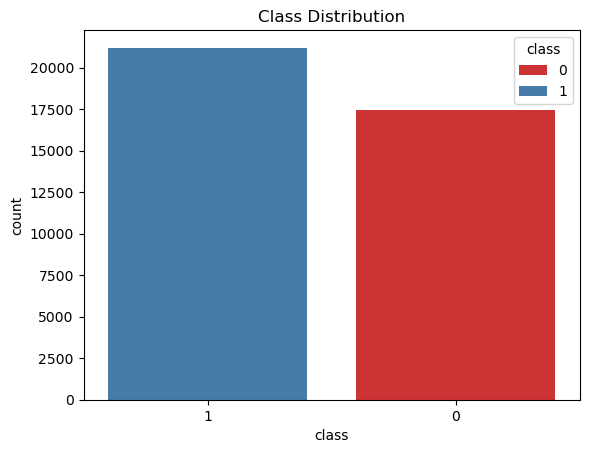

In [121]:
sns.countplot(data=data, 
              x='class', 
              order=data['class'].value_counts().index,
              palette="Set1",hue='class')  
plt.title("Class Distribution")
plt.show()

In [122]:
data['class'].value_counts()

class
1    21192
0    17455
Name: count, dtype: int64

### Word Cloud For Fake News

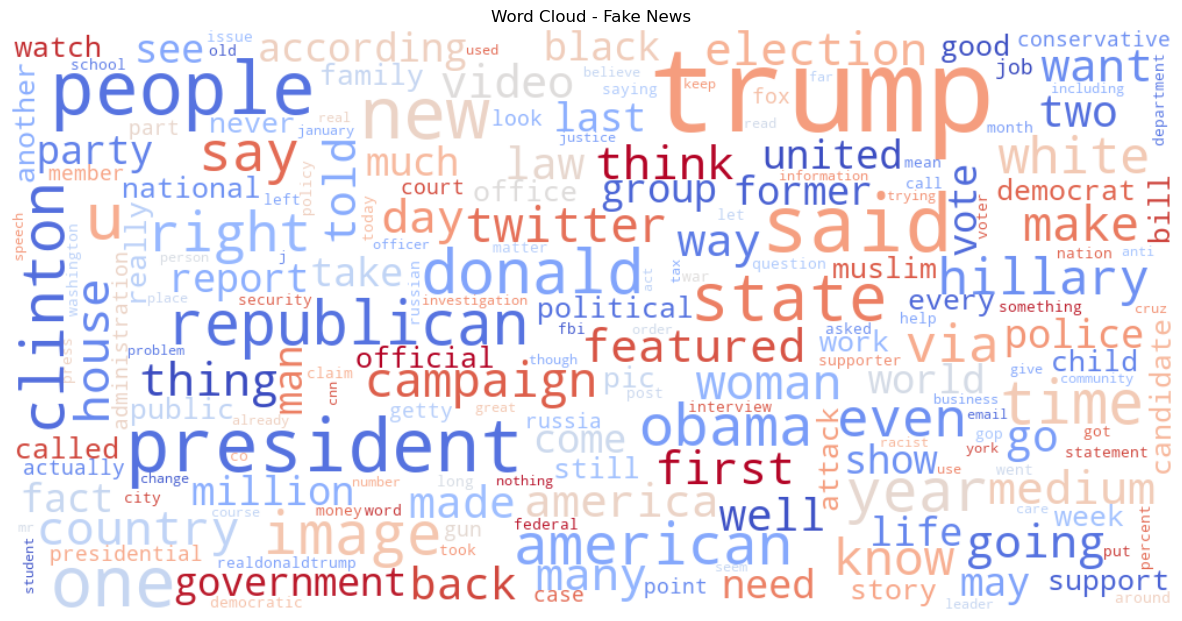

In [123]:
fake_news_text= ' '.join(
    word for word in data['text'][data['class'] == 0].astype(str))
wordCloud = WordCloud(width=1000,
                      height=500,
                      background_color="white",
                      colormap='coolwarm',
                      random_state=42,
                      max_font_size=100,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(fake_news_text), interpolation='bilinear')
plt.title("Word Cloud - Fake News")
plt.axis('off')
plt.show()

### Word Cloud For True News

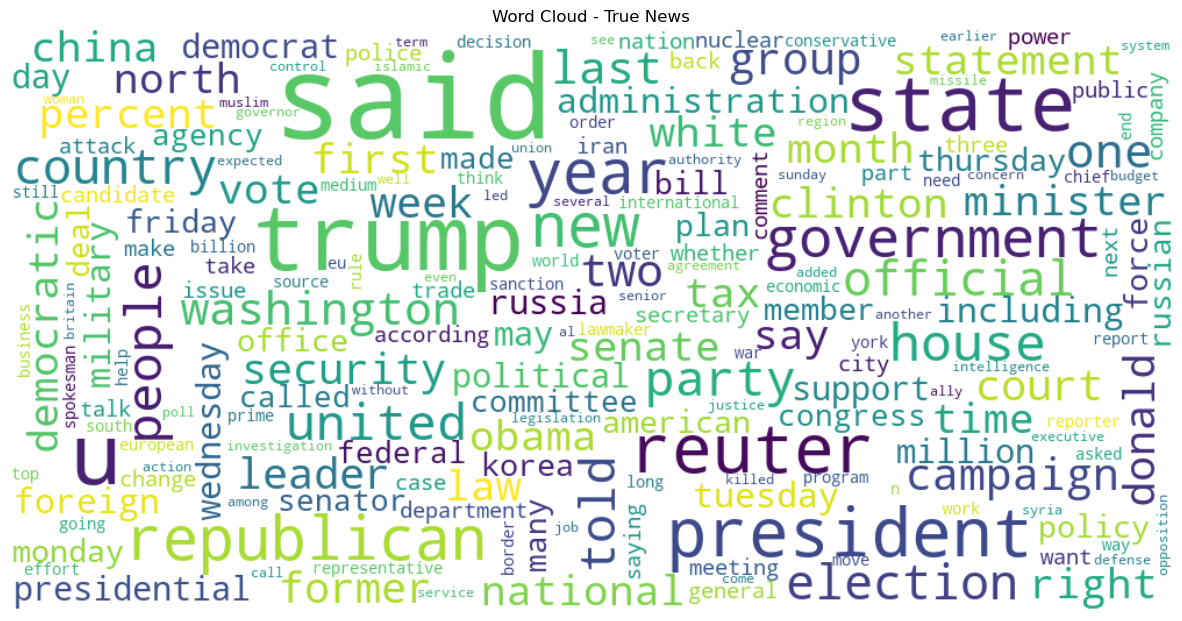

In [124]:
true_news_text = ' '.join(
    word for word in data['text'][data['class'] == 1].astype(str))
wordCloud = WordCloud(width=1000,
                      height=500,
                      background_color="white",
                      random_state=42,
                      max_font_size=100,
                      collocations=False)
plt.figure(figsize=(15, 10))
plt.imshow(wordCloud.generate(true_news_text), interpolation='bilinear')
plt.title("Word Cloud - True News")
plt.axis('off')
plt.show()

## Assigning Dependent And Independent Variable X And Y

In [125]:
x = data['text']
y = data['class'] 

## Train Test Split



In [126]:
# splits data into 70% training and 30% testing
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3,stratify=y,random_state=42,shuffle=True) 

## Text Vectorisation using TF-IDF



In [127]:
# converts raw text data into numerical form (vectoriser is only fit on training data to avoid data leakage)
vectorisation = TfidfVectorizer(min_df=5,max_df=0.7,max_features=10000)
vx_train = vectorisation.fit_transform(x_train) 
vx_test = vectorisation.transform(x_test)

## K-Fold Cross Validation Setup


In [128]:
#Split the training data into 5 folds 
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 

## Logistic Regression - Hyperparameter Tuning With Cross Validation (Training)


In [129]:
# initialise the model
LR=LogisticRegression(random_state=42) 

# define the hyperparameters to try
lr_param_grid={ 
    'C':[0.001,0.01,0.1],
    'penalty': ['l2'],
    'solver':['liblinear']
}
# search for the best hyperparameter combination using grid search with cross-validation
lr_grid_search= GridSearchCV(LR,lr_param_grid,cv=kf,scoring='accuracy',n_jobs=-1,verbose=1)  

# fit the model on the training data using the best parameters
lr_grid_search.fit(vx_train,y_train) 

# print out results from the hyperparameter search
print("Best Hyperparameter Search Results (Logistic Regression Model)")
print("\n")
print(f"Best Hyperparameters: {lr_grid_search.best_params_}") 
print("\n")
print(f"Best Cross-Validated Accuracy: {lr_grid_search.best_score_*100}%") 

# store best estimator to use in final evaluation
best_lr=lr_grid_search.best_estimator_ 

#store best cross-validated accuracy to compare with other models later
lr_cv_acc= lr_grid_search.best_score_*100


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best Hyperparameter Search Results (Logistic Regression Model)


Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Best Cross-Validated Accuracy: 95.92633271514076%


## Logistic Regression - Final Evaluation (Testing)

Final Evaluation Results (Tuned Logistic Regression Model)


Test accuracy:96.13626563173781%


Classification Report:


              precision    recall  f1-score   support

           0       0.97      0.94      0.96      5237
           1       0.95      0.98      0.97      6358

    accuracy                           0.96     11595
   macro avg       0.96      0.96      0.96     11595
weighted avg       0.96      0.96      0.96     11595





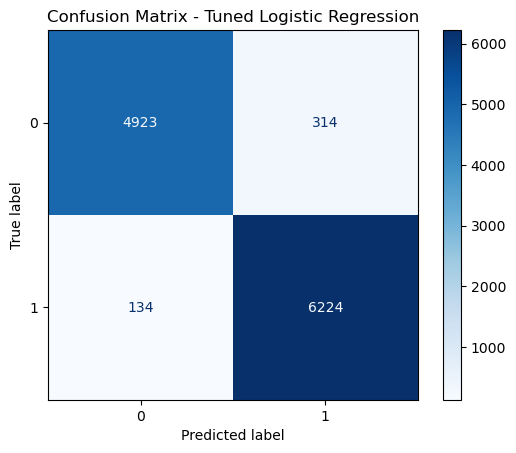

In [130]:

# use the best estimator to make predictions on test set
lr_prediction=best_lr.predict(vx_test) 

# print out test results
print("Final Evaluation Results (Tuned Logistic Regression Model)")
print("\n")
print(f"Test accuracy:{ accuracy_score(y_test, lr_prediction)*100}%") 
print("\n")
print("Classification Report:")
print("\n")
print(classification_report(y_test, lr_prediction)) 
print("\n")
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, lr_prediction))
cm.plot(cmap="Blues")
plt.title("Confusion Matrix - Tuned Logistic Regression")
plt.grid(False)
plt.show()



# store test accuracy to compare with other models later
lr_test_acc=accuracy_score(y_test, lr_prediction)*100

## Multinomial Naive Bayes - - Hyperparameter Tuning With Cross Validation (Training)

In [131]:
# initialise the model
NB = MultinomialNB()

# define the hyperparameters to try
nb_param_grid = {
    'alpha': [0.1, 0.5, 1, 5] 
}

# search for the best hyperparameter combination using grid search with cross-validation
nb_grid_search = GridSearchCV(NB, nb_param_grid, cv=kf, scoring='accuracy', n_jobs=-1, verbose=1)

# fit the model on the training data using the best parameters
nb_grid_search.fit(vx_train, y_train)

# print out results from the hyperparameter search
print("Best Hyperparameter Search Results (Multinomial Naive Bayes Model)")
print("\n")
print(f"Best Hyperparameters: {nb_grid_search.best_params_}")
print("\n")
print(f"Best Cross-Validated Accuracy: {nb_grid_search.best_score_ * 100}%")
print("\n")

# store best estimator to use in final evaluation
best_nb = nb_grid_search.best_estimator_

#store best cross-validated accuracy to compare with other models later
nb_cv_acc= nb_grid_search.best_score_*100

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Hyperparameter Search Results (Multinomial Naive Bayes Model)


Best Hyperparameters: {'alpha': 0.1}


Best Cross-Validated Accuracy: 93.31284974026005%




## Multinomial Naive Bayes - Final Evaluation (Testing)

Final Evaluation Results (Tuned Multinomial Naive Bayes Model)


Test accuracy: 93.17809400603709%


Classification Report:


              precision    recall  f1-score   support

           0       0.92      0.93      0.92      5237
           1       0.94      0.93      0.94      6358

    accuracy                           0.93     11595
   macro avg       0.93      0.93      0.93     11595
weighted avg       0.93      0.93      0.93     11595





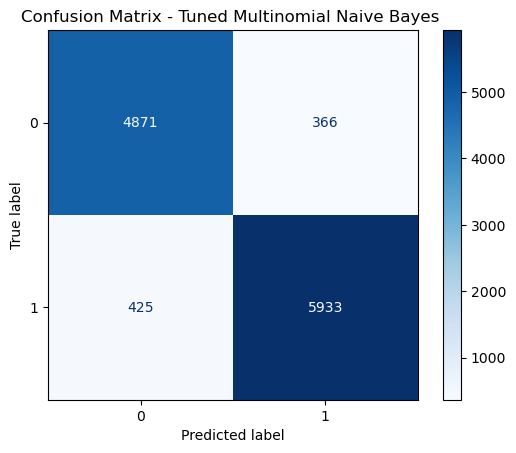

In [147]:
# use the best estimator to make predictions on test set
nb_prediction = best_nb.predict(vx_test)

# print out test results
print("Final Evaluation Results (Tuned Multinomial Naive Bayes Model)")
print("\n")
print(f"Test accuracy: {accuracy_score(y_test, nb_prediction) * 100}%")
print("\n")
print("Classification Report:")
print("\n")
print(classification_report(y_test, nb_prediction))
print("\n")
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, nb_prediction))
cm.plot(cmap="Blues")
plt.title("Confusion Matrix - Tuned Multinomial Naive Bayes ")
plt.grid(False)
plt.show()

# store test accuracy to compare with other models later
nb_test_acc=accuracy_score(y_test, nb_prediction)*100

## Random Forest - - Hyperparameter Tuning With Cross Validation (Training)


In [133]:
# initialise the model
RF=RandomForestClassifier(random_state=42) 

# define the hyperparameters to try
rf_param_grid={ 
    'n_estimators':[100,200,300],
    'max_depth':[5,10,15],
    'min_samples_split':[5,10,15],
    'min_samples_leaf': [4,6,10]  
}

# search for the best hyperparameter combination using grid search with cross-validation
rf_grid_search= GridSearchCV(RF,rf_param_grid,cv=kf,scoring='accuracy',n_jobs=-1,verbose=1)  

# fit the model on the training data using the best parameters
rf_grid_search.fit(vx_train,y_train) 

# print out results from the hyperparameter search
print("Best Hyperparameter Search Results (Random Forest Model)")
print("\n")
print(f"Best Hyperparameters: {rf_grid_search.best_params_}") 
print("\n")
print(f"Best Cross-Validated Accuracy: {rf_grid_search.best_score_*100}") 

# store best estimator to use in final evaluation
best_rf=rf_grid_search.best_estimator_ 

#store best cross-validated accuracy to compare with other models later
rf_cv_acc= rf_grid_search.best_score_*100


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Hyperparameter Search Results (Random Forest Model)


Best Hyperparameters: {'max_depth': 15, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


Best Cross-Validated Accuracy: 97.30149134832139


## Random Forest - Final Evaluation (Testing)

Final Evaluation Results (Tuned Random Forest Model)


Test accuracy:96.92108667529106%


Classification Report:


              precision    recall  f1-score   support

           0       1.00      0.94      0.96      5237
           1       0.95      1.00      0.97      6358

    accuracy                           0.97     11595
   macro avg       0.97      0.97      0.97     11595
weighted avg       0.97      0.97      0.97     11595





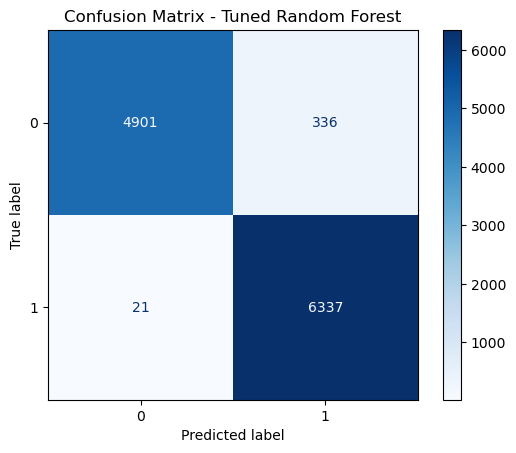

In [134]:
# use the best estimator to make predictions on test set
rf_prediction=best_rf.predict(vx_test) 

# print out test results
print("Final Evaluation Results (Tuned Random Forest Model)")
print("\n")
print(f"Test accuracy:{ accuracy_score(y_test, rf_prediction)*100}%") 
print("\n")
print("Classification Report:")
print("\n")
print(classification_report(y_test, rf_prediction)) 
print("\n")
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, rf_prediction))
cm.plot(cmap="Blues")
plt.title("Confusion Matrix - Tuned Random Forest")
plt.grid(False)
plt.show()

# store test accuracy to compare with other models later
rf_test_acc=accuracy_score(y_test, rf_prediction)*100

##  Linear SVM - Hyperparameter Tuning With Cross Validation (Training)

In [144]:
# initialise the model
SVM = LinearSVC(random_state=42) 

# define the hyperparameters to try
svm_param_grid = {
    'C': [0.001,0.01,0.1]
    
}

# search for the best hyperparameter combination using grid search with cross-validation
svm_grid_search = GridSearchCV(SVM, svm_param_grid, cv=kf, scoring='accuracy', n_jobs=-1, verbose=1)

# fit the model on the training data using the best parameters
svm_grid_search.fit(vx_train, y_train)

# print out results from the hyperparameter search
print("Best Hyperparameter Search Results (Linear SVM Model)")
print("\n")
print(f"Best Hyperparameters: {svm_grid_search.best_params_}")
print("\n")
print(f"Best Cross-Validated Accuracy: {svm_grid_search.best_score_ * 100}%")
print("\n")

# store best estimator to use in final evaluation
best_svm = svm_grid_search.best_estimator_

#store best cross-validated accuracy to compare with other models later
svm_cv_acc= svm_grid_search.best_score_*100

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\Hadee\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Best Hyperparameter Search Results (Linear SVM Model)


Best Hyperparameters: {'C': 0.1}


Best Cross-Validated Accuracy: 98.54723536740212%




## Linear SVM - Final Evaluation (Testing)

Final Evaluation Results (Tuned Linear SVM Model)


Test Accuracy: 98.51660198361363%


Classification Report:


              precision    recall  f1-score   support

           0       0.99      0.98      0.98      5237
           1       0.98      0.99      0.99      6358

    accuracy                           0.99     11595
   macro avg       0.99      0.98      0.99     11595
weighted avg       0.99      0.99      0.99     11595





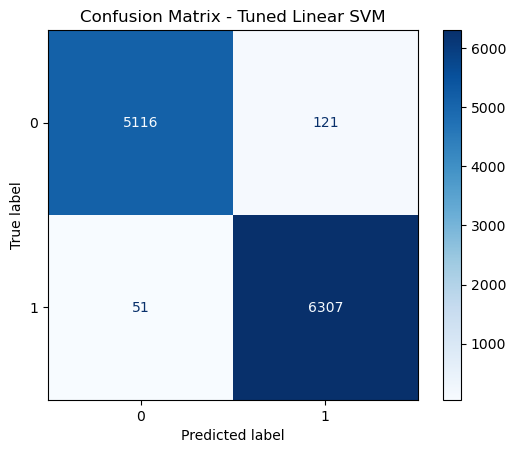

In [136]:
# use the best estimator to make predictions on test set
svm_prediction = best_svm.predict(vx_test)

# print out test results
print("Final Evaluation Results (Tuned Linear SVM Model)")
print("\n")
print(f"Test Accuracy: {accuracy_score(y_test, svm_prediction) * 100}%")
print("\n")
print("Classification Report:")
print("\n")
print(classification_report(y_test, svm_prediction))
print("\n")
cm = ConfusionMatrixDisplay(confusion_matrix(y_test, svm_prediction))
cm.plot(cmap="Blues")
plt.title("Confusion Matrix - Tuned Linear SVM")
plt.grid(False)
plt.show()

# store test accuracy to compare with other models later
svm_test_acc=accuracy_score(y_test, svm_prediction)*100

## Model Accuracy Comparison For Cross Validation


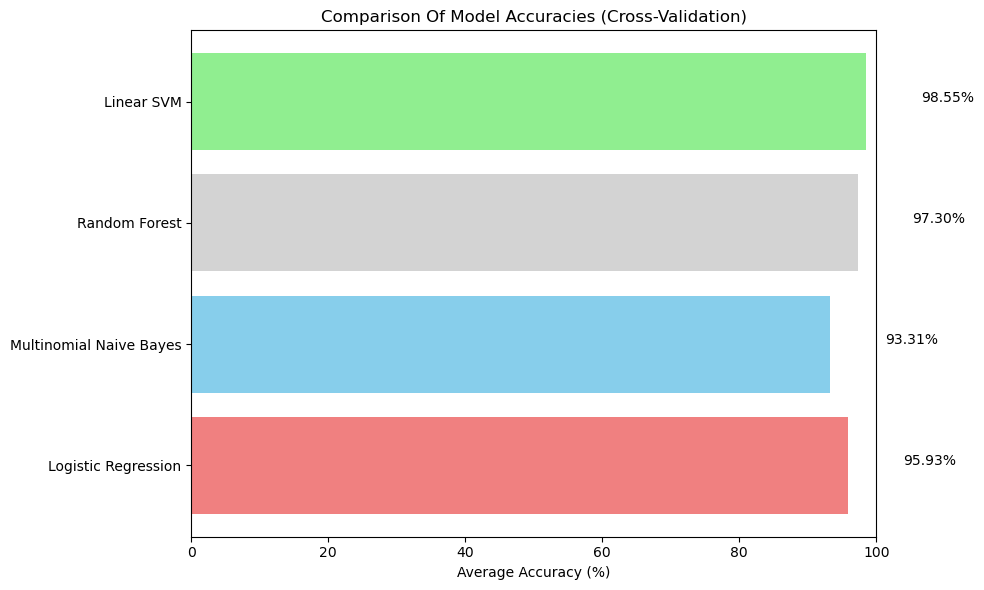

In [151]:
model_name = ["Logistic Regression","Multinomial Naive Bayes", "Random Forest","Linear SVM"]
accuracies_cv = [lr_cv_acc,nb_cv_acc, rf_cv_acc,svm_cv_acc]
colours = ["lightcoral", "skyblue", "lightgray","lightgreen"]
plt.figure(figsize=(10, 6))
plt.barh(model_name, accuracies_cv,color=colours)
plt.xlabel("Average Accuracy (%)")
plt.title("Comparison Of Model Accuracies (Cross-Validation)")
plt.xlim(0, 100)
plt.grid(False)

for i in range(len(model_name)):
    plt.text(accuracies_cv[i] + 8, i, f"{accuracies_cv[i]:.2f}%")
    
plt.tight_layout()
plt.show()

## Model Accuracy Comparison For Final Evaluation

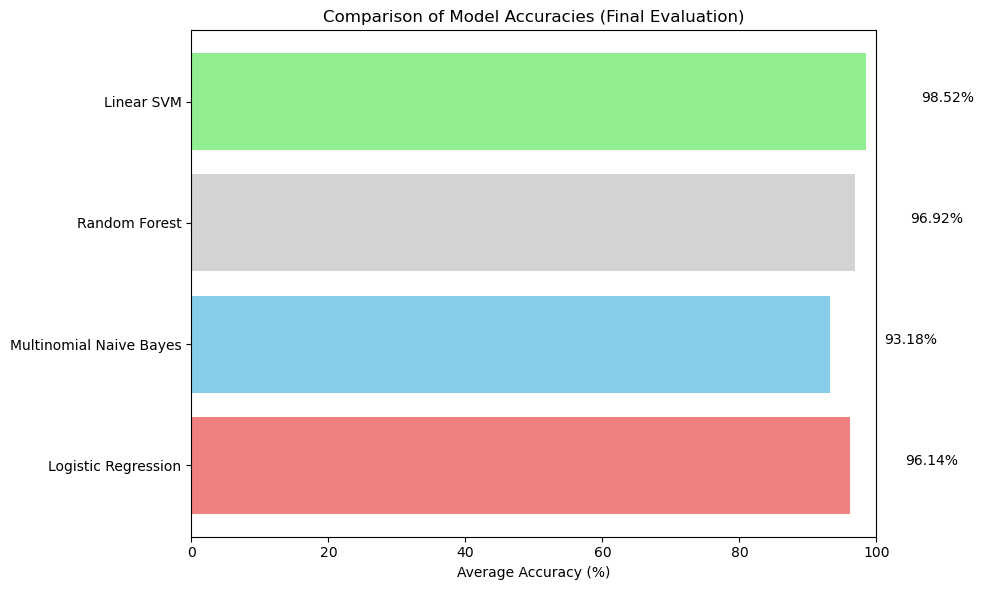

In [153]:
model_names = ["Logistic Regression","Multinomial Naive Bayes", "Random Forest","Linear SVM"]
accuracies_test = [lr_test_acc, nb_test_acc ,rf_test_acc,svm_test_acc]
colours = ["lightcoral", "skyblue", "lightgray","lightgreen"]
plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies_test,color=colours)
plt.xlabel("Average Accuracy (%)")
plt.title("Comparison of Model Accuracies (Final Evaluation)")
plt.xlim(0, 100)
plt.grid(False)

for i in range(len(model_names)):
    plt.text(accuracies_test[i] + 8, i, f"{accuracies_test[i]:.2f}%")

plt.tight_layout()
plt.show()

## Prediction output (For Demo)

In [158]:
# news article to be tested
news_article = "Democrats are saying thatâ€™s not enough, we need to give the government a pay raise of 10 to 11 percent. For a fiscal conservative, I donâ€™t see where the rationale is. ... Eventually you run out of other peopleâ€™s money,â€ he said. Meadows was among Republicans who voted in late December for their partyâ€™s debt-financed tax overhaul, which is expected to balloon the federal budget deficit and add about $1.5 trillion over 10 years to the $20 trillion national debt. â€œItâ€™s interesting to hear Mark talk about fiscal responsibility,â€ Democratic U.S. Representative Joseph Crowley said on CBS. Crowley said the Republican tax bill would require the  United States to borrow $1.5 trillion, to be paid off by future generations, to finance tax cuts for corporations and the rich. â€œThis is one of the least ... fiscally responsible bills weâ€™ve ever seen passed in the history of the House of Representatives. I think weâ€™re going to be paying for this for many, many years to come,â€ Crowley said. Republicans insist the tax package, the biggest U.S. tax overhaul in more than 30 years,  will boost the economy and job growth. House Speaker Paul Ryan, who also supported the tax bill, recently went further than Meadows, making clear in a radio interview that welfare or â€œentitlement reform,â€ as the party often calls it, would be a top Republican priority in 2018. In Republican parlance, â€œentitlementâ€ programs mean food stamps, housing assistance, Medicare and Medicaid health insurance for the elderly, poor and disabled, as well as other programs created by Washington to assist the needy. Democrats seized on Ryanâ€™s early December remarks, saying they showed Republicans would try to pay for their tax overhaul by seeking spending cuts for social programs. But the goals of House Republicans may have to take a back seat to the Senate, where the votes of some Democrats will be needed to approve a budget and prevent a government shutdown. Democrats will use their leverage in the Senate, which Republicans narrowly control, to defend both discretionary non-defense programs and social spending, while tackling the issue of the â€œDreamers,â€ people brought illegally to the country as children. Trump in September put a March 2018 expiration date on the Deferred Action for Childhood Arrivals, or DACA, program, which protects the young immigrants from deportation and provides them with work permits. The president has said in recent Twitter messages he wants funding for his proposed Mexican border wall and other immigration law changes in exchange for agreeing to help the Dreamers. Representative Debbie Dingell told CBS she did not favor linking that issue to other policy objectives, such as wall funding. â€œWe need to do DACA clean,â€ she said.  On Wednesday, Trump aides will meet with congressional leaders to discuss those issues. That will be followed by a weekend of strategy sessions for Trump and Republican leaders on Jan. 6 and 7, the White House said. Trump was also scheduled to meet on Sunday with Florida Republican Governor Rick Scott, who wants more emergency aid. The House has passed an $81 billion aid package after hurricanes in Florida, Texas and Puerto Rico, and wildfires in California. The package far exceeded the $44 billion requested by the Trump administration. The Senate has not yet voted on the aid. " 

# clean the news article 
cleaned_article = clean_data(new_article)

# apply vectorisation to news article
vectorised_article = vectorisation.transform([cleaned_article])  

# make prediction using one of the models
prediction = best_lr.predict(vectorised_article)

# print out if article if real or fake
if prediction[0] == 1:
    print("News article is real")
else:
    print("News article is fake")

News article is real
